In [1]:
import pandas as pd
import random
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle
import zipfile
import os

In [2]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\raiom.LAPTOP-
[nltk_data]     59QT21KS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\raiom.LAPTOP-
[nltk_data]     59QT21KS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
if torch.cuda.is_available():       
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
import transformers
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, AdamW, BertConfig
from transformers.optimization import get_linear_schedule_with_warmup

In [5]:
true_zip = r"C:\Users\raiom.LAPTOP-59QT21KS\Downloads\True.csv.zip"
pth1 = r"C:\Users\raiom.LAPTOP-59QT21KS\FakeNews\true"

In [6]:
fake_zip = r"C:\Users\raiom.LAPTOP-59QT21KS\Downloads\Fake.csv.zip"
pth2 = r"C:\Users\raiom.LAPTOP-59QT21KS\FakeNews\fake"

In [7]:
with zipfile.ZipFile(true_zip, 'r') as true:
    true.extractall(pth1)

In [8]:
with zipfile.ZipFile(fake_zip, 'r') as fake:
    fake.extractall(pth2)

In [9]:
true_pth = os.path.join(pth1, "True.csv")
true_data = pd.read_csv(true_pth)

In [10]:
true_data.drop(columns = ["title", "subject", "date"], inplace = True)

In [11]:
true_data['label'] = 0

In [12]:
true_data.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,0
1,WASHINGTON (Reuters) - Transgender people will...,0
2,WASHINGTON (Reuters) - The special counsel inv...,0
3,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,0


In [13]:
true_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21417 non-null  object
 1   label   21417 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.8+ KB


In [14]:
fake_pth = os.path.join(pth2, "Fake.csv")
fake_data = pd.read_csv(fake_pth)

In [15]:
fake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [16]:
fake_data = fake_data.iloc[:21417]

In [17]:
fake_data.drop(columns = ["title", "subject", "date"], inplace = True)

In [18]:
fake_data["label"] = True

In [19]:
fake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21417 non-null  object
 1   label   21417 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 188.4+ KB


In [20]:
fake_data.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,True
1,House Intelligence Committee Chairman Devin Nu...,True
2,"On Friday, it was revealed that former Milwauk...",True
3,"On Christmas day, Donald Trump announced that ...",True
4,Pope Francis used his annual Christmas Day mes...,True


In [21]:
dataframe = pd.concat([true_data, fake_data], axis = 0)

In [22]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42834 entries, 0 to 21416
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    42834 non-null  object
 1   label   42834 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1003.9+ KB


In [23]:
dataframe['text'] = dataframe['text'].str.replace(r'^.*\(Reuters\)\s*-\s*', '', regex=True)

In [24]:
dataframe.iloc[12210,0]

'Brazilian President Michel Temer was cleared to leave hospital in Sao Paulo on Friday and will return to Brasilia in the afternoon, his office said. Temer, 77, underwent minor surgery on Wednesday for a narrowing of his urethra. [L1N1OD2AC] '

In [25]:
def text_preprocessing(text):
    text = re.sub(r"[!@#$()-,\n\"%^*?:.;~\[\]]", " ", text)
    words = text.lower().split()
    words = [word.replace("'", "") for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)

In [26]:
dataframe['text'] = dataframe['text'].apply(text_preprocessing)

In [27]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42834 entries, 0 to 21416
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    42834 non-null  object
 1   label   42834 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1003.9+ KB


In [28]:
dataframe['text'] = dataframe['text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))

In [29]:
for i in range(3):
    dataframe = dataframe.sample(frac = 1)
    if i == 2:
        dataframe = dataframe.sample(frac = 1).reset_index(drop = True)

In [30]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case = True)
tokenizer.save_pretrained('utils/models/tokenizer')

('utils/models/tokenizer\\tokenizer_config.json',
 'utils/models/tokenizer\\special_tokens_map.json',
 'utils/models/tokenizer\\vocab.txt',
 'utils/models/tokenizer\\added_tokens.json')

In [31]:
X_train, X_test = train_test_split(dataframe, test_size=0.2, random_state = 45)

In [32]:
texts = X_train['text']

In [33]:
def sliding_window_tokenization(text, tokenizer, max_length=512, stride=128):

    encoded_chunks = tokenizer(
        text,
        max_length=max_length,
        truncation=True,
        stride=stride,
        return_overflowing_tokens=True,
        return_tensors="pt",
        return_attention_mask = True,
        padding='max_length'
    )
    
    return encoded_chunks

In [34]:
input_ids_texts = []
attention_masks_texts = []

In [35]:
def tokenization(texts, input_ids_texts, attention_masks_texts):
    for i, text in enumerate(texts):
        encoded_chunks = sliding_window_tokenization(text, tokenizer)
        
        num_chunks = len(encoded_chunks['input_ids'])
        
        input_ids_texts.append(encoded_chunks['input_ids'])
        attention_masks_texts.append(encoded_chunks['attention_mask'])
    
    input_ids_texts = torch.cat(input_ids_texts, dim=0)
    attention_masks_texts = torch.cat(attention_masks_texts, dim=0)
    return input_ids_texts, attention_masks_texts
input_ids_texts, attention_masks_texts = tokenization(texts, input_ids_texts, attention_masks_texts)

In [36]:
Y = torch.tensor(X_train['label'].values)

In [37]:
dataset = TensorDataset(
         input_ids_texts,
         attention_masks_texts,
         Y
        )

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

30,840 training samples
3,427 validation samples


In [38]:
batch_size = 16

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [39]:
model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels = 2,
        output_attentions = False,
        output_hidden_states = False,
        dropout = 0.4
)

model.cuda()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.4, inplace=False)


In [40]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8,
                  weight_decay = 0.01
                 )

In [41]:
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [42]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [43]:
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds = elapsed_rounded))

In [44]:
torch.cuda.empty_cache()
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()
    
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        outputs = model(b_input_ids, 
                             # token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss = outputs.loss
        logits = outputs.logits
        
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                                   # token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids) 
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of  1,928.    Elapsed: 0:00:28.
  Batch    80  of  1,928.    Elapsed: 0:00:56.
  Batch   120  of  1,928.    Elapsed: 0:01:24.
  Batch   160  of  1,928.    Elapsed: 0:01:53.
  Batch   200  of  1,928.    Elapsed: 0:02:21.
  Batch   240  of  1,928.    Elapsed: 0:02:50.
  Batch   280  of  1,928.    Elapsed: 0:03:18.
  Batch   320  of  1,928.    Elapsed: 0:03:47.
  Batch   360  of  1,928.    Elapsed: 0:04:15.
  Batch   400  of  1,928.    Elapsed: 0:04:44.
  Batch   440  of  1,928.    Elapsed: 0:05:13.
  Batch   480  of  1,928.    Elapsed: 0:05:41.
  Batch   520  of  1,928.    Elapsed: 0:06:10.
  Batch   560  of  1,928.    Elapsed: 0:06:39.
  Batch   600  of  1,928.    Elapsed: 0:07:07.
  Batch   640  of  1,928.    Elapsed: 0:07:36.
  Batch   680  of  1,928.    Elapsed: 0:08:05.
  Batch   720  of  1,928.    Elapsed: 0:08:34.
  Batch   760  of  1,928.    Elapsed: 0:09:02.
  Batch   800  of  1,928.    Elapsed: 0:09:31.
  Batch   840  of

In [45]:
pd.set_option('display.precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,6.83e-02,0.04,0.99,0:23:08,0:00:49
2,1.59e-02,0.04,0.99,0:23:14,0:00:49
3,9.88e-03,0.02,1.00,0:23:20,0:00:49
4,3.10e-03,0.03,1.00,0:23:11,0:00:49
5,2.40e-03,0.03,1.00,0:23:07,0:00:49


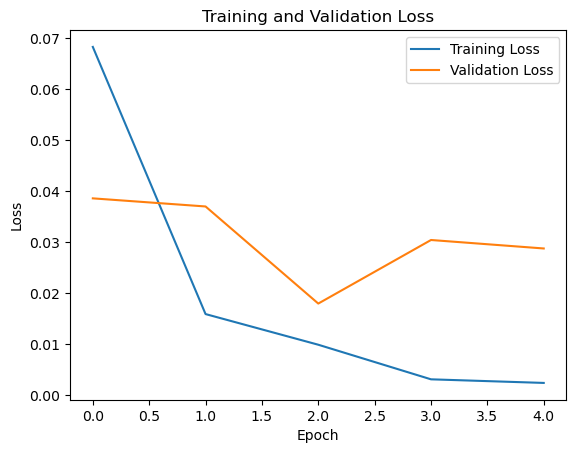

In [46]:
# Extract loss and accuracy values
training_loss_values = [stat['Training Loss'] for stat in training_stats]
validation_loss_values = [stat['Valid. Loss'] for stat in training_stats]

# Plot loss over epochs
plt.plot(training_loss_values, label='Training Loss')
plt.plot(validation_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

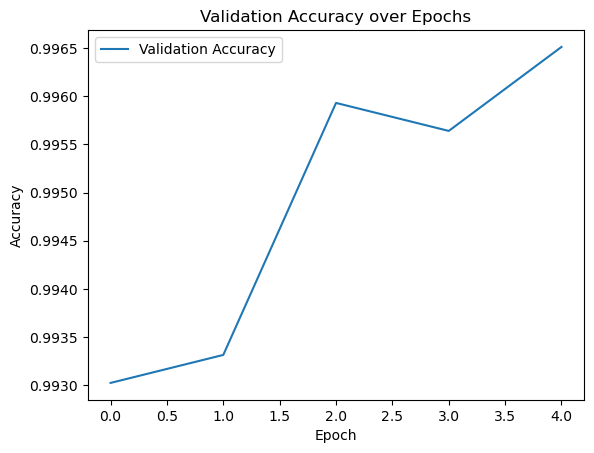

In [47]:
validation_accuracy_values = [stat['Valid. Accur.'] for stat in training_stats]
plt.plot(validation_accuracy_values, label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [48]:
texts_tst = X_test['text']

In [49]:
input_ids_texts = []
attention_masks_texts = []

In [50]:
input_ids_texts, attention_masks_texts = tokenization(texts, input_ids_texts, attention_masks_texts)

In [51]:
Y_tst = torch.tensor(X_test['label'].values)

In [52]:
prediction_data = TensorDataset(
         input_ids_texts,
         attention_masks_texts,
         Y
        )
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler = prediction_sampler, batch_size = batch_size)

In [53]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.4, inplace=False)


In [54]:
predictions, true_labels = [], []
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, 
                        #token_type_ids = None, 
                        attention_mask = b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.append(logits)
    true_labels.append(label_ids)

In [55]:
print('Positive samples: %d of %d (%.2f%%)' % (X_test.label.sum(), len(X_test.label), (X_test.label.sum() / len(X_test.label) * 100.0)))

Positive samples: 4318 of 8567 (50.40%)


In [56]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []

print('Calculating Matthews Corr. Cef. for eact batch...')

for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i], axis =1).flatten()
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
    matthews_set.append(matthews)

Calculating Matthews Corr. Cef. for eact batch...


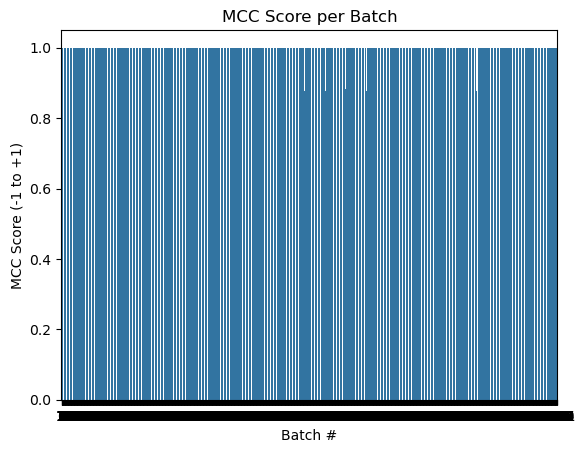

In [57]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, errorbar=None)
plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')
plt.show()

In [58]:
flat_predictions = np.concatenate(predictions, axis = 0)
flat_predictions = np.argmax(flat_predictions, axis = 1).flatten()
flat_true_labels = np.concatenate(true_labels, axis = 0)
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC:%.3f' %mcc)

Total MCC:0.998


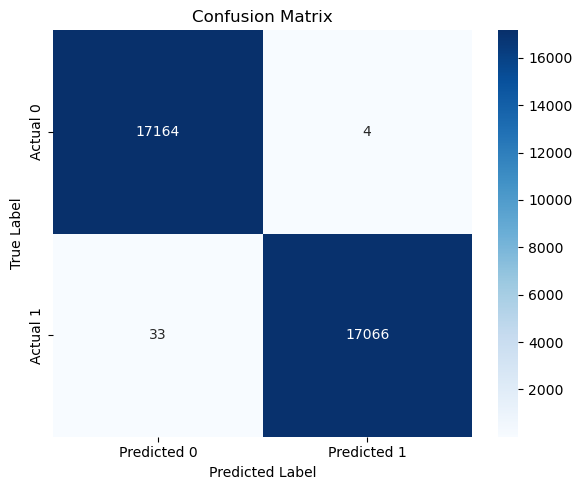

In [59]:
cm = confusion_matrix(flat_true_labels, flat_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [60]:
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17168
           1       1.00      1.00      1.00     17099

    accuracy                           1.00     34267
   macro avg       1.00      1.00      1.00     34267
weighted avg       1.00      1.00      1.00     34267



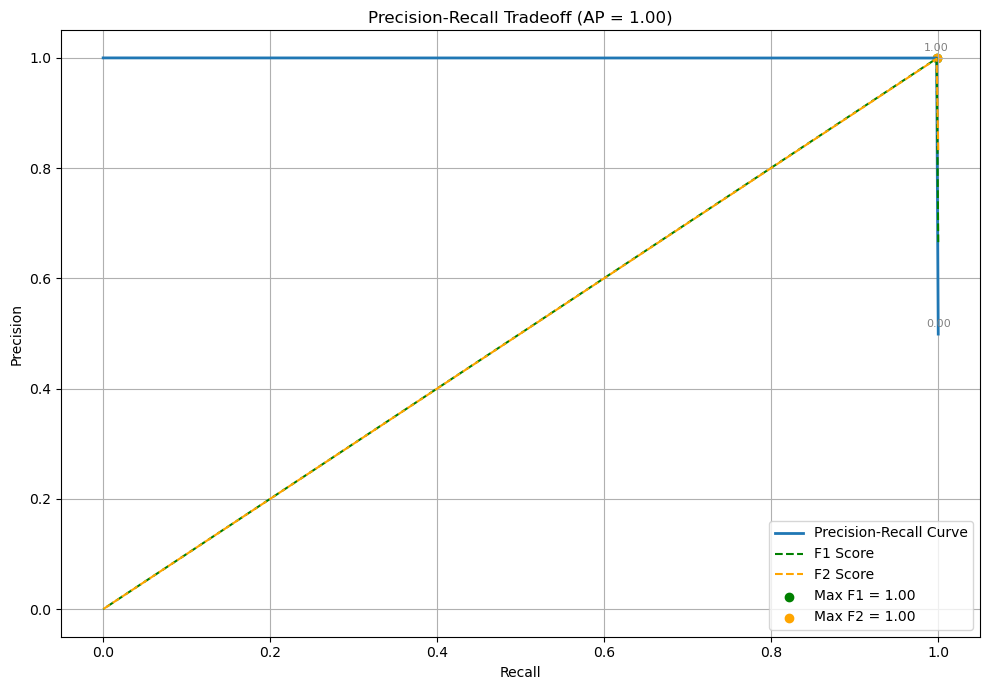

In [61]:
precision, recall, thresholds = precision_recall_curve(flat_true_labels, flat_predictions)
avg_precision = average_precision_score(flat_true_labels, flat_predictions)

# Calculate F1 and F2 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
beta = 2
f2_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + 1e-8)

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, label='Precision-Recall Curve', linewidth=2)
plt.title(f'Precision-Recall Tradeoff (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

# Annotate a few thresholds
for i in range(0, len(thresholds), max(1, len(thresholds)//10)):
    plt.annotate(f"{thresholds[i]:.2f}",
                 (recall[i], precision[i]),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='center',
                 fontsize=8,
                 color='gray')

# Overlay F1 and F2 scores
plt.plot(recall, f1_scores, linestyle='--', color='green', label='F1 Score')
plt.plot(recall, f2_scores, linestyle='--', color='orange', label='F2 Score')

# Highlight max F1 and F2 points
max_f1_idx = np.argmax(f1_scores)
max_f2_idx = np.argmax(f2_scores)

plt.scatter(recall[max_f1_idx], precision[max_f1_idx], marker='o', color='green', label=f'Max F1 = {f1_scores[max_f1_idx]:.2f}')
plt.scatter(recall[max_f2_idx], precision[max_f2_idx], marker='o', color='orange', label=f'Max F2 = {f2_scores[max_f2_idx]:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

In [63]:
with open('utils/models/fakenews_detection.pkl', 'wb') as fake_news:
    pickle.dump(model, fake_news)